# Keras forecasting for jena dataset

Notes from Chollet's [book](https://www.amazon.com.br/Deep-Learning-Python-Francois-Chollet/dp/1617294438/ref=sr_1_1?adgrpid=82022317140&dchild=1&gclid=CjwKCAjwmqKJBhAWEiwAMvGt6BqZ01AuTvd_dexj4ajY5Fm0I7BYAb_PQPg5SR9yu-JA0YVCcBS97xoCl-YQAvD_BwE&hvadid=426016012043&hvdev=c&hvlocphy=9100482&hvnetw=g&hvqmt=b&hvrand=3608483639682862243&hvtargid=kwd-305262673818&hydadcr=5656_11235223&keywords=deep+learning+with+python&qid=1630069713&sr=8-1&ufe=app_do%3Aamzn1.fos.4bb5663b-6f7d-4772-84fa-7c7f565ec65b). 



In [231]:
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from progressbar import progressbar

In [2]:
fname = 'data/jena_climate_2009_2016.csv'
df = pd.read_csv(fname)

In [3]:
df[:5]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

<AxesSubplot:xlabel='Date Time'>

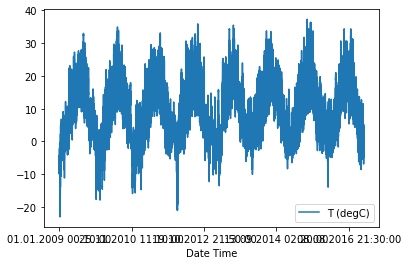

In [5]:
df.plot(x='Date Time', y='T (degC)')

<AxesSubplot:xlabel='Date Time'>

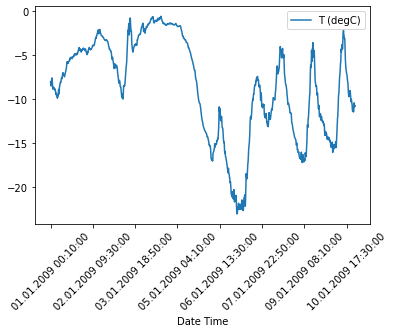

In [6]:
# first 10 days (data is recorded every 10 min)
df[:10*24*6].plot(x='Date Time', y='T (degC)', rot=45)

In [7]:
# standard scaler

X = df[df.columns[1:]].values
mean = X[:200000].mean(axis=0)
X -= mean
std = X[:200000].std(axis=0)
X /= std

In [8]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    """
      data: The original array of floating-point data (normalized)
      lookback: How many timesteps back the input data should go.
      delay: How many timesteps in the future the target should be.
      min_index and max_index—Indices in the data array that delimit which time-steps to draw from.
      This is useful for keeping a segment of the data for validation and another for testing.
      shuffle: Whether to shuffle the samples or draw them in chronological order.
      batch_size: The number of samples per batch.
      step: The period, in timesteps, at which you sample data.
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros(
             (len(rows),
             lookback // step,
             data.shape[-1]))
        targets = np.zeros((len(rows)))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

Let's use the abstract generator function to instantiate three generators: one for training, one for validation, and one for testing. 

Each will look at different temporal segments of the original data: 
the training generator looks at the first 200,000 time-steps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.


In [9]:
lookback = 10*24*6 # (days*hours*step) Observations will go back 5 days.
step = 6 # Observations will be sampled at one data point per hour.
delay = 144 # Targets will be 24 hours in the future.
batch_size = 128


train_gen = generator(X,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(X,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(X,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [10]:
# How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)

# How many steps to draw from test_gen in order to see the entire test set
test_steps = (len(X) - 300001 - lookback)

In [11]:
# Baseline model: naive predictor (temperature tomorrow = temperature right now)

def evaluate_naive_method():
    batch_maes = []
    for step in progressbar(range(val_steps)):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [120]:
evaluate_naive_method()

100% (98559 of 98559) |##################| Elapsed Time: 0:14:16 Time:  0:14:16


0.2896957472219946


In [12]:
baseline_mae = 0.2896957472219946

In [13]:
# this is equivalent to 
print(f"{round((baseline_mae)*std[1] ,2)} degree C MAE")

2.56 degree C MAE


### A basic machine-learning approach 

In [17]:
val_steps

98559

In [ ]:
128*20

In [18]:
from keras.models import Sequential 
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, X.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen, 
                    steps_per_epoch=batch_size*4,
                    epochs=20, 
                    validation_data=val_gen, 
                    validation_steps=batch_size*4)


Epoch 1/20
512/512 [==============================] - 22s 41ms/step - loss: 1.2229 - val_loss: 0.6781
Epoch 2/20
512/512 [==============================] - 20s 39ms/step - loss: 0.4120 - val_loss: 0.3433
Epoch 3/20
512/512 [==============================] - 21s 41ms/step - loss: 0.2913 - val_loss: 0.2884
Epoch 4/20
512/512 [==============================] - 25s 50ms/step - loss: 0.2684 - val_loss: 0.3420
Epoch 5/20
512/512 [==============================] - 19s 36ms/step - loss: 0.2553 - val_loss: 0.3348
Epoch 6/20
512/512 [==============================] - 18s 35ms/step - loss: 0.2447 - val_loss: 0.3120
Epoch 7/20
512/512 [==============================] - 20s 39ms/step - loss: 0.2387 - val_loss: 0.3344
Epoch 8/20
512/512 [==============================] - 29s 57ms/step - loss: 0.2316 - val_loss: 0.3308
Epoch 9/20
512/512 [==============================] - 21s 40ms/step - loss: 0.2257 - val_loss: 0.3023
Epoch 10/20
512/512 [==============================] - 18s 36ms/step - loss: 0.221

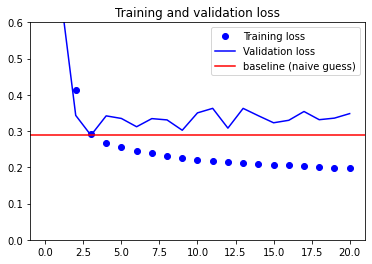

In [22]:
loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axline((0, baseline_mae), (20, baseline_mae), color='red', label='baseline (naive guess)')
plt.ylim(0, 0.6)
plt.title('Training and validation loss')
plt.legend()
plt.show()

### GRU model

In [28]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, X.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=test_steps//batch_size,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps//batch_size)

/Users/valdirsalustino/Documents/git/keras-forecasting/venv/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
929/929 [==============================] - 217s 230ms/step - loss: 0.2986 - val_loss: 0.2690
Epoch 2/20
929/929 [==============================] - 209s 225ms/step - loss: 0.2758 - val_loss: 0.2630
Epoch 3/20
929/929 [==============================] - 235s 253ms/step - loss: 0.2669 - val_loss: 0.2635
Epoch 4/20
929/929 [==============================] - 207s 223ms/step - loss: 0.2556 - val_loss: 0.2669
Epoch 5/20
929/929 [==============================] - 195s 210ms/step - loss: 0.2466 - val_loss: 0.2687
Epoch 6/20
929/929 [==============================] - 187s 201ms/step - loss: 0.2389 - val_loss: 0.2828
Epoch 7/20
929/929 [==============================] - 215s 231ms/step - loss: 0.2316 - val_loss: 0.2850
Epoch 8/20
929/929 [==============================] - 197s 212ms/step - loss: 0.2235 - val_loss: 0.2878
Epoch 9/20
929/929 [==============================] - 196s 211ms/step - loss: 0.2158 - val_loss: 0.2945
Epoch 10/20
929/929 [==============================] - 195s 210m

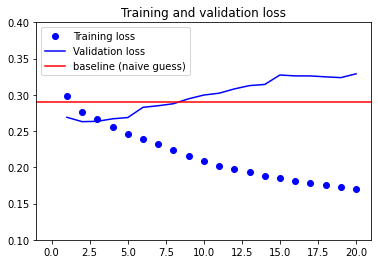

In [31]:
loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axline((0, baseline_mae), (20, baseline_mae), color='red', label='baseline (naive guess)')
plt.ylim(0.1, 0.4)
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [220]:
test_gen_data = generator(X, 
                          lookback=lookback, 
                          delay=delay, 
                          min_index=300001, 
                          max_index=None, 
                          step=step, 
                          batch_size=1)

In [221]:
# sample, target = next(test_gen_data)

In [222]:
# pred = model.predict_generator(test_gen_data)

In [243]:
truth = []
pred = []

for i in range(test_steps)[:100]:
    x, y = next(test_gen_data)
    pred.append(model.predict(x))
    truth.append(y) 

pred = np.concatenate(pred)
truth = np.concatenate(truth)

### GRU regularized with dropout

In [251]:
model = Sequential()

model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, X.shape[-1])))

model.add(layers.GRU(64, 
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=test_steps//batch_size,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps//batch_size)

Epoch 1/40
929/929 [==============================] - 649s 693ms/step - loss: 0.3117 - val_loss: 0.2733
Epoch 2/40
929/929 [==============================] - 890s 958ms/step - loss: 0.2889 - val_loss: 0.2761
Epoch 3/40
929/929 [==============================] - 888s 956ms/step - loss: 0.2768 - val_loss: 0.2673
Epoch 4/40
929/929 [==============================] - 1030s 1s/step - loss: 0.2692 - val_loss: 0.2765
Epoch 5/40
929/929 [==============================] - 892s 960ms/step - loss: 0.2596 - val_loss: 0.2826
Epoch 6/40
929/929 [==============================] - 704s 758ms/step - loss: 0.2504 - val_loss: 0.2961
Epoch 7/40
929/929 [==============================] - 923s 994ms/step - loss: 0.2429 - val_loss: 0.2988
Epoch 8/40
929/929 [==============================] - 734s 790ms/step - loss: 0.2361 - val_loss: 0.3123
Epoch 9/40
929/929 [==============================] - 651s 701ms/step - loss: 0.2297 - val_loss: 0.3076
Epoch 10/40
929/929 [==============================] - 630s 678ms/

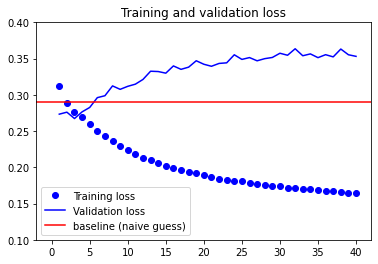

In [252]:
loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axline((0, baseline_mae), (40, baseline_mae), color='red', label='baseline (naive guess)')
plt.ylim(0.1, 0.4)
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Bidirectional GRU

In [254]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), 
                               input_shape=(None, X.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=test_steps//batch_size,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=val_steps//batch_size)

Epoch 1/10
929/929 [==============================] - 277s 292ms/step - loss: 0.2883 - val_loss: 0.2718
Epoch 2/10
929/929 [==============================] - 314s 338ms/step - loss: 0.2672 - val_loss: 0.2814
Epoch 3/10
929/929 [==============================] - 262s 282ms/step - loss: 0.2553 - val_loss: 0.2673
Epoch 4/10
929/929 [==============================] - 399s 430ms/step - loss: 0.2441 - val_loss: 0.2766
Epoch 5/10
929/929 [==============================] - 415s 447ms/step - loss: 0.2340 - val_loss: 0.2809
Epoch 6/10
929/929 [==============================] - 425s 457ms/step - loss: 0.2213 - val_loss: 0.2899
Epoch 7/10
929/929 [==============================] - 328s 354ms/step - loss: 0.2102 - val_loss: 0.2997
Epoch 8/10
929/929 [==============================] - 305s 328ms/step - loss: 0.1988 - val_loss: 0.2993
Epoch 9/10
929/929 [==============================] - 296s 318ms/step - loss: 0.1904 - val_loss: 0.3103
Epoch 10/10
929/929 [==============================] - 279s 300m

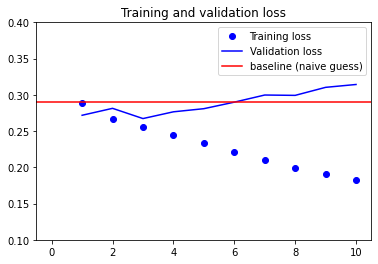

In [256]:
loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.axline((0, baseline_mae), (10, baseline_mae), color='red', label='baseline (naive guess)')
plt.ylim(0.1, 0.4)
plt.title('Training and validation loss')
plt.legend()
plt.show()